##Load Libraries

In [64]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import preprocessing, impute
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
import pickle
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use("ggplot")

##Import The Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omarzaghloul","key":"01e4a7d3603583e961165b7cb026d33c"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d jsphyg/weather-dataset-rattle-package

Dataset URL: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
License(s): other
  0% 0.00/3.83M [00:00<?, ?B/s]
100% 3.83M/3.83M [00:00<00:00, 258MB/s]


In [6]:
!unzip weather-dataset-rattle-package.zip

Archive:  weather-dataset-rattle-package.zip
  inflating: weatherAUS.csv          


In [7]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


##Data Cleaning

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [9]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [10]:
df.describe(include='object')

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2013-11-12,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


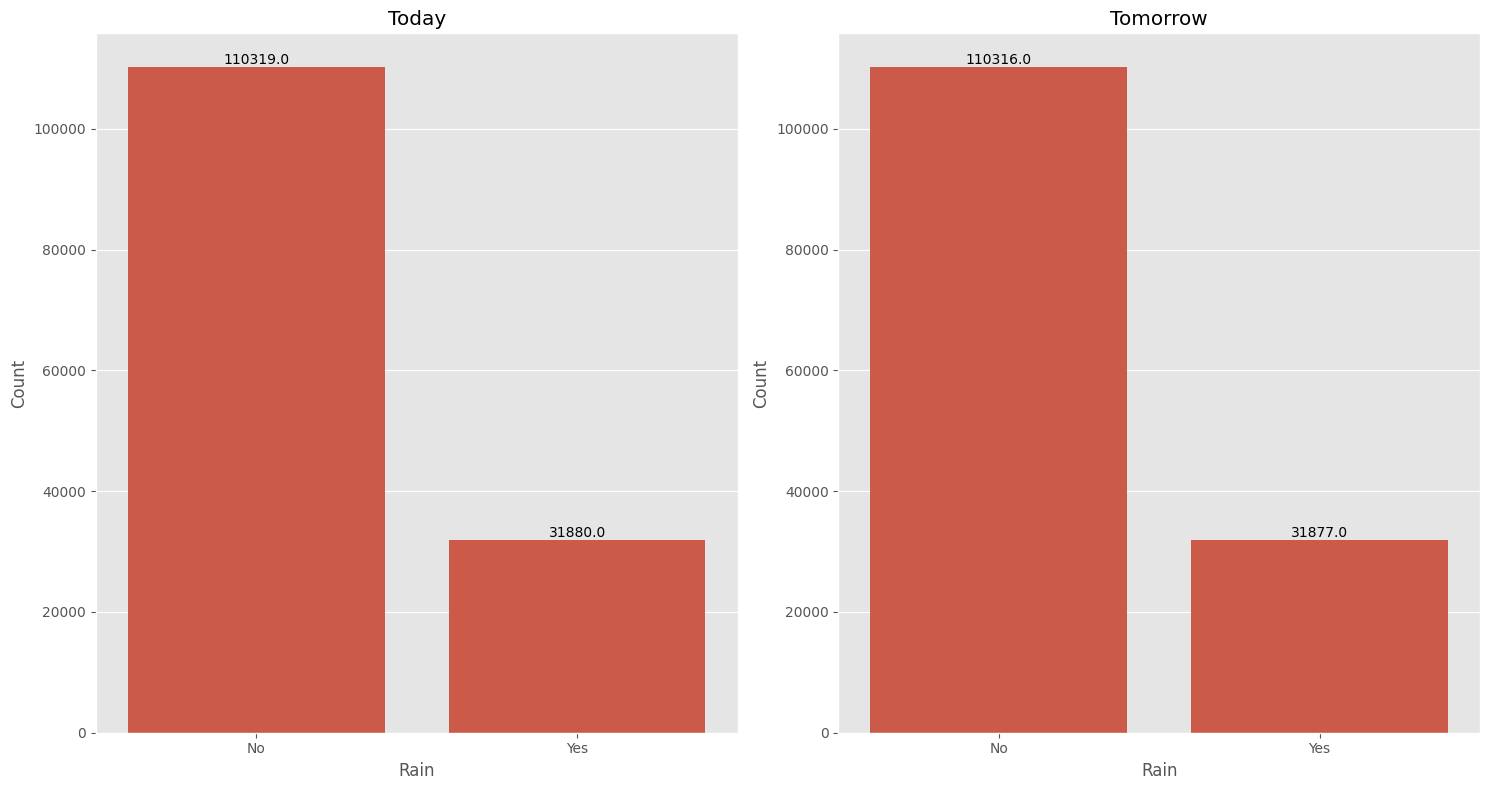

In [11]:
figure, axes = plt.subplots(1, 2, figsize = (15, 8))

sns.countplot(data = df, x = 'RainToday', ax = axes[0])
axes[0].set(title = 'Today', xlabel = "Rain", ylabel = "Count")
sns.countplot(data = df, x = 'RainTomorrow', ax = axes[1])
axes[1].set(title = 'Tomorrow', xlabel = "Rain", ylabel = "Count")

for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom')
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
del figure, axes
pd.crosstab(df['RainToday'], df['RainTomorrow'])

RainTomorrow,No,Yes
RainToday,,
No,92728,16604
Yes,16858,14597


In [13]:
df.dropna(axis=0, subset=['RainToday', 'RainTomorrow'], inplace=True)

In [14]:
categorical_features = df.select_dtypes(include = ['object']).columns.tolist()
numerical_features = df.select_dtypes(include = ['float64']).columns.tolist()

print('Number of numerical independent features: ', len(numerical_features))
print('Number of categorical independent features: ', len(categorical_features))

Number of numerical independent features:  16
Number of categorical independent features:  7


In [15]:
df.shape

(140787, 23)

##Data distributions

16it [00:24,  1.55s/it]


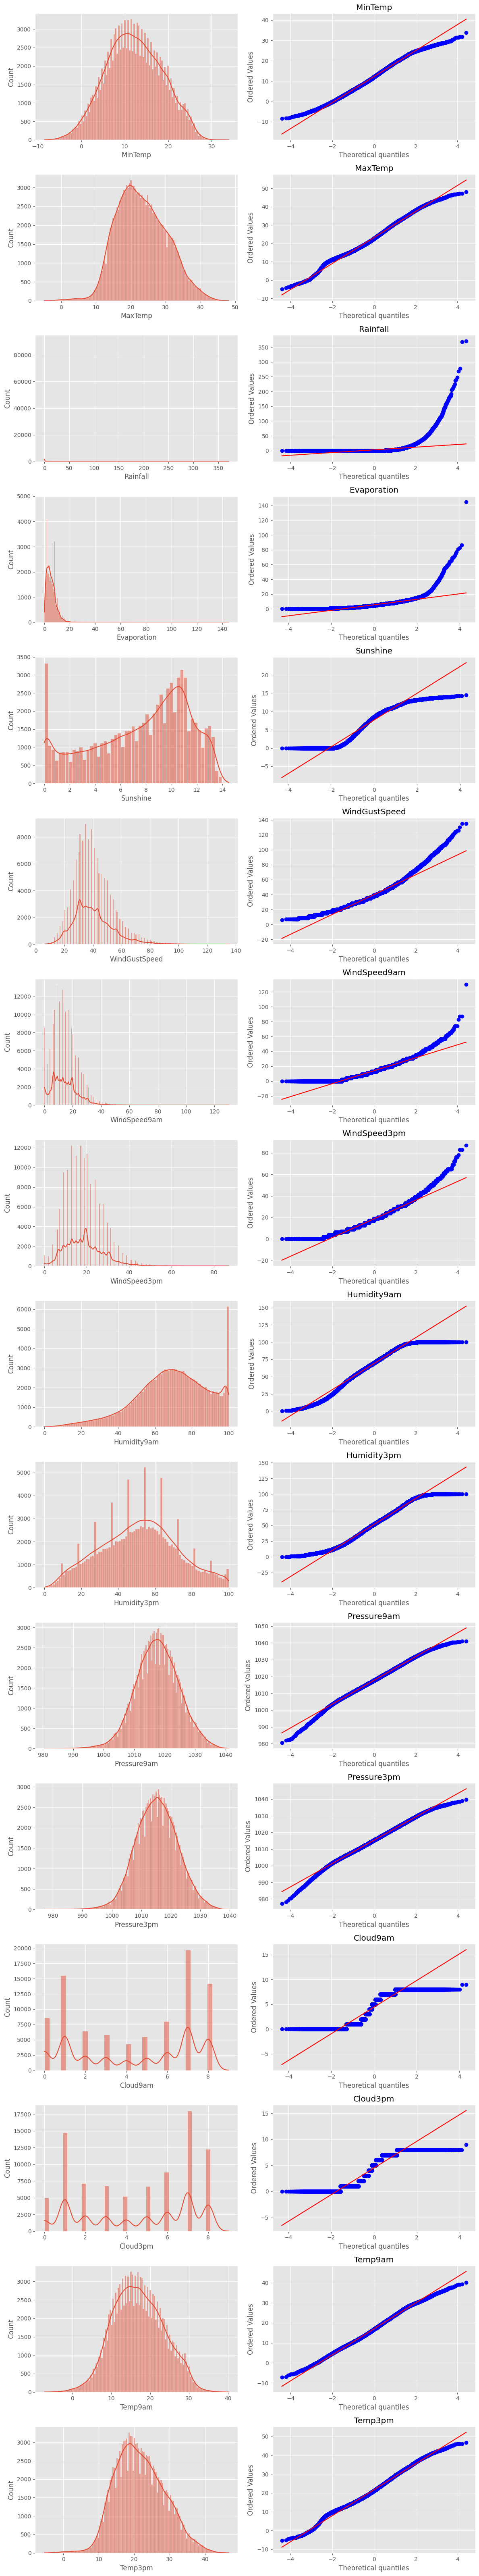

In [16]:
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, len(numerical_features)*4))

for i, col in tqdm(enumerate(numerical_features)):
    sns.histplot(df[col], ax = axes[i, 0], kde =True)
    stats.probplot(df[col].dropna(), dist='norm', plot=axes[i, 1])
    axes[i, 1].set_title(col)

plt.tight_layout()
plt.show()

In [17]:
def get_nan(dataframe):
    total_nan = dataframe.isnull().sum()
    percent_nan = round(dataframe.isnull().sum()/len(dataframe)*100, 2)
    nan_col = pd.concat([total_nan, percent_nan], axis=1, keys=['Total', 'Percent'])
    nan_col = nan_col[nan_col['Total'] > 0].sort_values(by = ['Total'], ascending = False)
    return nan_col


def eda(dataframe, features):
    data_info = [{"Minimum": dataframe[col].min(), "Maximum": dataframe[col].max(), "Mode": dataframe[col].mode()[0]} for col in features]
    return pd.DataFrame(data_info, index = features).T

In [18]:
eda(df, numerical_features)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
Minimum,-8.5,-4.8,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,980.5,977.1,0.0,0.0,-7.2,-5.4
Maximum,33.9,48.1,371.0,145.0,14.5,135.0,130.0,87.0,100.0,100.0,1041.0,1039.6,9.0,9.0,40.2,46.7
Mode,9.6,20.0,0.0,4.0,0.0,35.0,9.0,13.0,99.0,52.0,1016.4,1015.5,7.0,7.0,17.0,20.0


##Missing Values

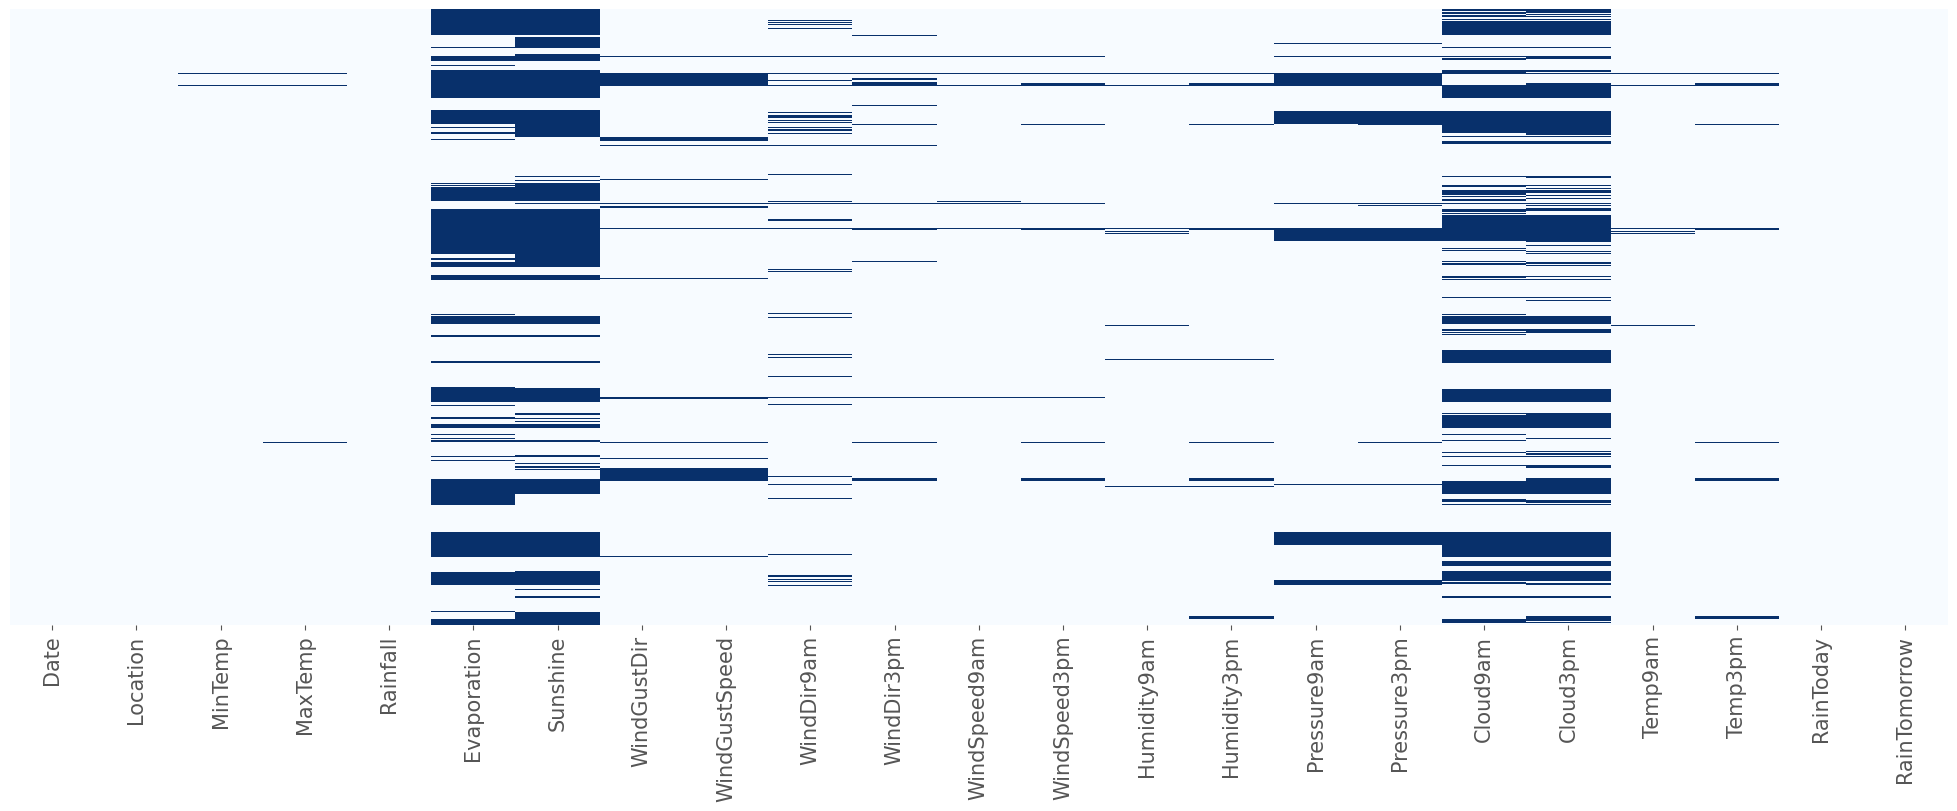

In [19]:
plt.figure(figsize = (25,8))
sns.heatmap(df.isnull(), cbar=False, cmap='Blues', yticklabels=False)
plt.xticks(fontsize = 15)
plt.ylabel(None)
plt.show()

In [20]:
get_nan(df).T

,Sunshine,Evaporation,Cloud3pm,Cloud9am,Pressure3pm,Pressure9am,WindDir9am,WindGustDir,WindGustSpeed,WindDir3pm,Humidity3pm,Temp3pm,WindSpeed3pm,Humidity9am,WindSpeed9am,Temp9am,MinTemp,MaxTemp
Total,66805.00,59694.0,56094.00,52625.00,13769.00,13743.00,9660.00,9163.00,9105.00,3670.00,3501.00,2624.00,2531.0,1517.00,1055.00,656.00,468.00,307.00
Percent,47.45,42.4,39.84,37.38,9.78,9.76,6.86,6.51,6.47,2.61,2.49,1.86,1.8,1.08,0.75,0.47,0.33,0.22


## Categorical Missing Values

In [21]:
modes = df[categorical_features[1:-2]].apply(pd.Series.mode).to_dict("list")
modes = {i:modes[i][0] for i in modes}
df_cat = df[categorical_features].dropna()
loc_cat = df_cat.groupby(['Location'])[categorical_features[1:-2]].agg(pd.Series.mode)
del df_cat

print(loc_cat.shape[0], df.Location.nunique())
loc_cat.T

47 49


Location,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Location,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
WindGustDir,WSW,W,ESE,E,N,SSE,E,SE,NW,SW,NE,SSW,E,SSE,NNW,E,NNW,N,N,SSW,NNE,N,W,W,S,E,SE,E,SE,SW,E,W,SE,W,SSW,W,S,ENE,NW,E,ENE,SE,N,WNW,SSE,NE,SSE
WindDir9am,NNE,SE,ESE,SW,N,SSE,SW,SSE,NNW,NE,SW,N,SE,SSE,NNW,SE,NNW,N,N,S,NNE,N,W,S,SSW,E,NE,E,SSW,E,ENE,N,SSW,W,N,W,NW,SE,NW,E,E,NW,ENE,WNW,SE,SW,SE
WindDir3pm,WSW,W,ESE,"[E, NNE]",N,N,ENE,SE,WNW,SW,NE,SSW,WNW,SE,SE,ESE,NNW,S,S,S,SW,S,W,W,NE,SE,WSW,SW,NE,SW,WSW,W,ENE,E,S,E,NE,ENE,NW,E,WSW,SSE,SSW,SE,SSE,NE,SSW


In [22]:
pendings = list(set(df.Location.unique().tolist()) - set(loc_cat.index.tolist()))
print(pendings)

['Albany', 'Newcastle']


In [23]:
for loc in pendings:
    x = df[df['Location'] == loc][categorical_features[1:-2]].apply(pd.Series.mode)
    x.fillna(modes, inplace = True)
    x.index = [loc]
    loc_cat = pd.concat([loc_cat, x], axis = 0)
loc_cat.T

,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,Albany,Newcastle
Location,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,Albany,Newcastle
WindGustDir,WSW,W,ESE,E,N,SSE,E,SE,NW,SW,NE,SSW,E,SSE,NNW,E,NNW,N,N,SSW,NNE,N,W,W,S,E,SE,E,SE,SW,E,W,SE,W,SSW,W,S,ENE,NW,E,ENE,SE,N,WNW,SSE,NE,SSE,W,W
WindDir9am,NNE,SE,ESE,SW,N,SSE,SW,SSE,NNW,NE,SW,N,SE,SSE,NNW,SE,NNW,N,N,S,NNE,N,W,S,SSW,E,NE,E,SSW,E,ENE,N,SSW,W,N,W,NW,SE,NW,E,E,NW,ENE,WNW,SE,SW,SE,NW,NW
WindDir3pm,WSW,W,ESE,"[E, NNE]",N,N,ENE,SE,WNW,SW,NE,SSW,WNW,SE,SE,ESE,NNW,S,S,S,SW,S,W,W,NE,SE,WSW,SW,NE,SW,WSW,W,ENE,E,S,E,NE,ENE,NW,E,WSW,SSE,SSW,SE,SSE,NE,SSW,ESE,SE


In [24]:
loc_cat.shape

(49, 4)

In [25]:
for l in tqdm(df.Location.unique()):
    indices = df[df['Location'] == l].index
    modes = loc_cat.loc[l].values.tolist()

    if len(modes) >= 3:
        x, y, z = modes[:3]
    else:
        continue

    if isinstance(x, str):
        df.loc[indices, 'WindGustDir'] = df.loc[indices, 'WindGustDir'].fillna(x)
    else:
        if len(x) > 0:
            df.loc[indices, 'WindGustDir'] = df.loc[indices, 'WindGustDir'].fillna(x[0])
            loc_cat.loc[l, 'WindGustDir'] = x[0]

    if isinstance(y, str):
        df.loc[indices, 'WindDir9am'] = df.loc[indices, 'WindDir9am'].fillna(y)
    else:
        if len(y) > 0:
            df.loc[indices, 'WindDir9am'] = df.loc[indices, 'WindDir9am'].fillna(y[0])
            loc_cat.loc[l, 'WindDir9am'] = y[0]

    if isinstance(z, str):
        df.loc[indices, 'WindDir3pm'] = df.loc[indices, 'WindDir3pm'].fillna(z)
    else:
        if len(z) > 0:
            df.loc[indices, 'WindDir3pm'] = df.loc[indices, 'WindDir3pm'].fillna(z[0])
            loc_cat.loc[l, 'WindDir3pm'] = z[0]

100%|██████████| 49/49 [00:01<00:00, 40.29it/s]


In [26]:
df[categorical_features].isnull().sum().sum()

0

##Numerical Missing Values

In [27]:
loc_num = df.groupby(['Location'])[get_nan(df).index].mean()
loc_num.fillna(df[loc_num.columns].mean(), inplace = True)
for l in tqdm(df.Location.unique()):
    indices = df[df['Location'] == l].index
    available_nan = get_nan(df).index
    for col in available_nan:
        df.loc[indices, col] = df.loc[indices, col].fillna(loc_num.loc[l, col])

100%|██████████| 49/49 [00:06<00:00,  7.38it/s]


In [28]:
df.isnull().sum().sum()

0

In [29]:
imputer = pd.concat([loc_cat, loc_num], axis = 1)
imputer.T

,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,Albany,Newcastle
Location,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,Albany,Newcastle
WindGustDir,WSW,W,ESE,E,N,SSE,E,SE,NW,SW,NE,SSW,E,SSE,NNW,E,NNW,N,N,SSW,NNE,N,W,W,S,E,SE,E,SE,SW,E,W,SE,W,SSW,W,S,ENE,NW,E,ENE,SE,N,WNW,SSE,NE,SSE,W,W
WindDir9am,NNE,SE,ESE,SW,N,SSE,SW,SSE,NNW,NE,SW,N,SE,SSE,NNW,SE,NNW,N,N,S,NNE,N,W,S,SSW,E,NE,E,SSW,E,ENE,N,SSW,W,N,W,NW,SE,NW,E,E,NW,ENE,WNW,SE,SW,SE,NW,NW
WindDir3pm,WSW,W,ESE,"[E, NNE]",N,N,ENE,SE,WNW,SW,NE,SSW,WNW,SE,SE,ESE,NNW,S,S,S,SW,S,W,W,NE,SE,WSW,SW,NE,SW,WSW,W,ENE,E,S,E,NE,ENE,NW,E,WSW,SSE,SSW,SE,SSE,NE,SSW,ESE,SE
Sunshine,7.798305,7.63054,9.581944,7.63054,7.63054,7.63054,8.078988,7.578954,7.400266,8.674364,7.367293,6.409924,8.49931,7.63054,6.576302,7.63054,7.63054,6.507009,6.381283,8.468441,8.894347,6.511167,7.63054,7.63054,7.63054,7.025078,7.67981,8.978001,7.63054,8.784536,8.795306,6.488762,7.63054,6.683663,7.63054,7.173635,7.202613,8.463403,7.63054,7.63054,8.197864,7.63054,6.379157,7.142211,7.63054,7.63054,9.065367,6.659153,7.63054
Evaporation,5.826032,5.472516,9.029929,5.472516,5.472516,3.85173,5.408673,6.211976,4.405396,6.717983,3.904834,3.353041,6.319089,5.472516,3.601543,7.333198,6.166667,4.65074,4.644378,5.936622,7.618881,3.437072,5.472516,5.472516,5.472516,4.738026,5.085928,5.472516,5.472516,5.606579,5.662832,3.419116,5.252008,3.830098,5.472516,5.185396,5.25245,7.197927,5.472516,5.472516,5.159061,5.472516,4.635554,6.946521,5.472516,5.472516,10.113812,4.206126,5.472516
Cloud3pm,4.49925,5.426638,3.24298,4.49925,6.28319,4.858341,3.879553,4.429707,4.791377,3.847243,4.485108,4.49925,4.311383,4.49925,4.961824,3.156398,5.726531,5.302799,5.263298,3.920224,3.934286,5.471879,4.49925,4.49925,4.49925,4.838352,4.876063,3.941812,4.49925,3.46974,3.44426,6.067261,5.499133,5.092756,4.49925,4.218536,4.27091,4.011615,4.49925,4.817734,4.186743,4.49925,5.264972,4.317061,4.49925,5.857558,2.881849,4.807245,4.304452
Cloud9am,4.431161,6.407059,2.836364,4.431161,5.797739,4.396618,3.913446,4.552848,4.87484,3.290742,4.316369,4.431161,4.336572,4.431161,4.843225,2.555848,6.306834,5.270123,5.246261,3.386379,3.289003,5.513365,4.431161,4.431161,4.431161,4.988223,4.672816,3.748144,4.431161,3.383579,3.371467,6.33398,6.233333,5.344188,4.431161,4.182803,4.27294,4.293417,4.431161,5.585075,3.827474,4.431161,5.245151,4.449624,4.431161,6.235698,2.505335,5.190876,4.124865
Pressure3pm,1016.782775,1015.747606,1012.89325,1015.640417,1016.280795,1015.863588,1015.125431,1011.115216,1016.235638,1015.33912,1015.835386,1016.502655,1008.34837,1015.244425,1012.953551,1008.566364,1013.760256,1015.819556,1016.279096,1016.267433,1014.963477,1016.387802,1015.257963,1016.400447,1016.00833,1015.90051,1016.794846,1015.167848,1015.257963,1015.420457,1015.366789,1016.604035,1015.642195,1015.909271,1015.257963,1016.021767,1015.966878,1011.922167,1015.681153,1013.32425,1015.946112,1016.174386,1016.10592,1015.763963,1016.81493,1016.015869,1016.033165,1016.493035,1015.257963
Pressure9am,1018.739847,1018.360582,1016.709689,1018.450964,1017.868827,1018.017573,1018.256737,1014.16417,1018.987665,1018.004673,1018.229366,1017.994454,1011.888154,1017.946375,1014.521182,1012.878238,1015.679222,

##EDA

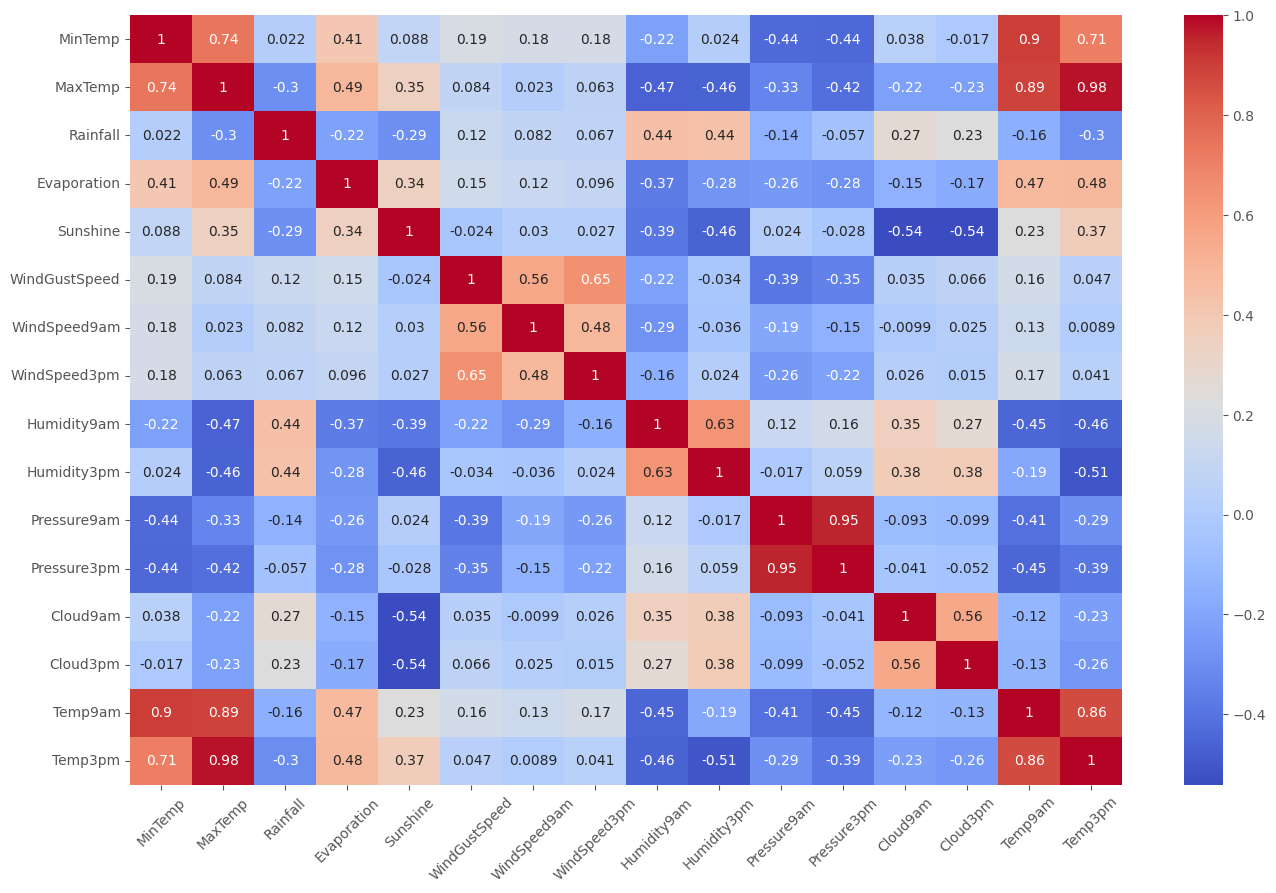

In [30]:
corri = df[numerical_features].corr(method = 'spearman')
plt.figure(figsize=(16,10))
sns.heatmap(corri, annot=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.show()

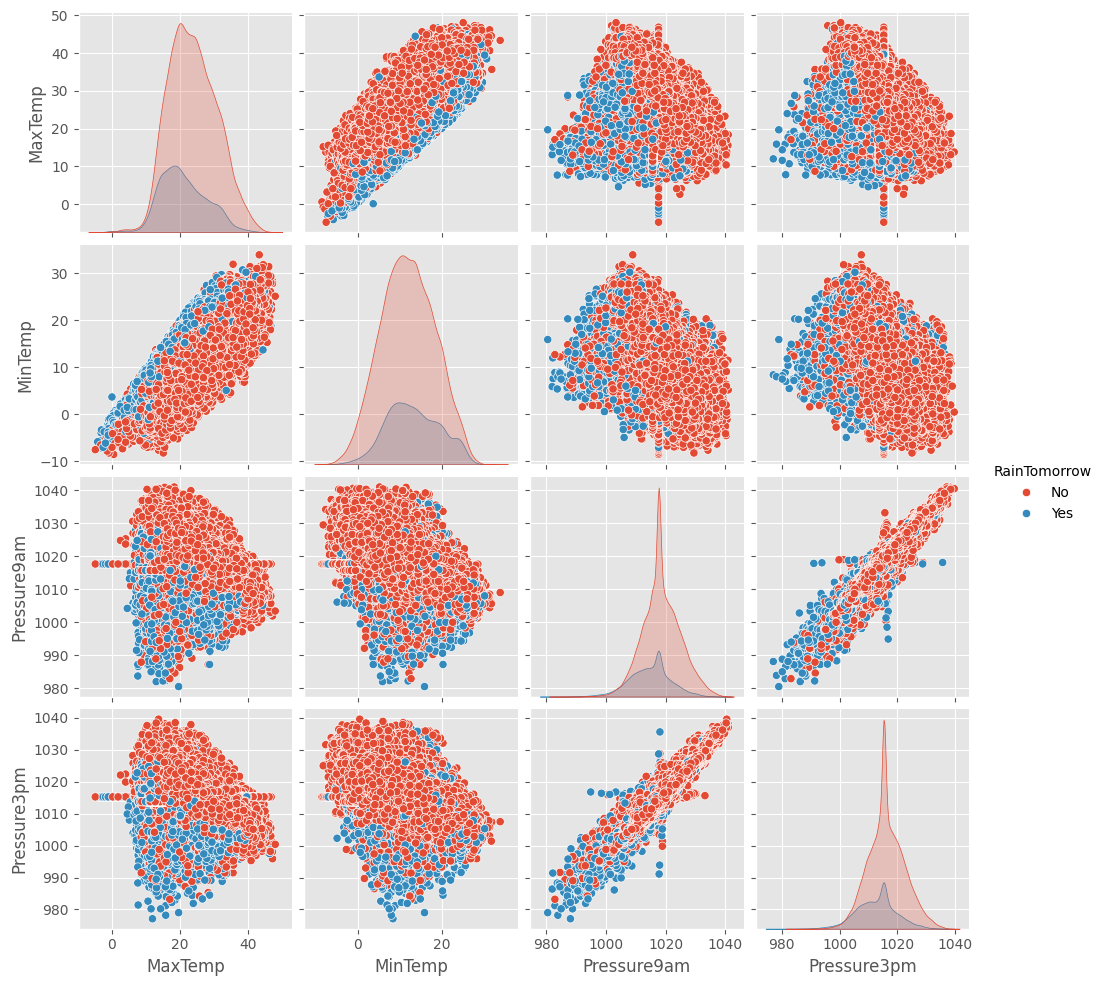

In [31]:
sns.pairplot(data=df, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm'), hue='RainTomorrow')
plt.show()

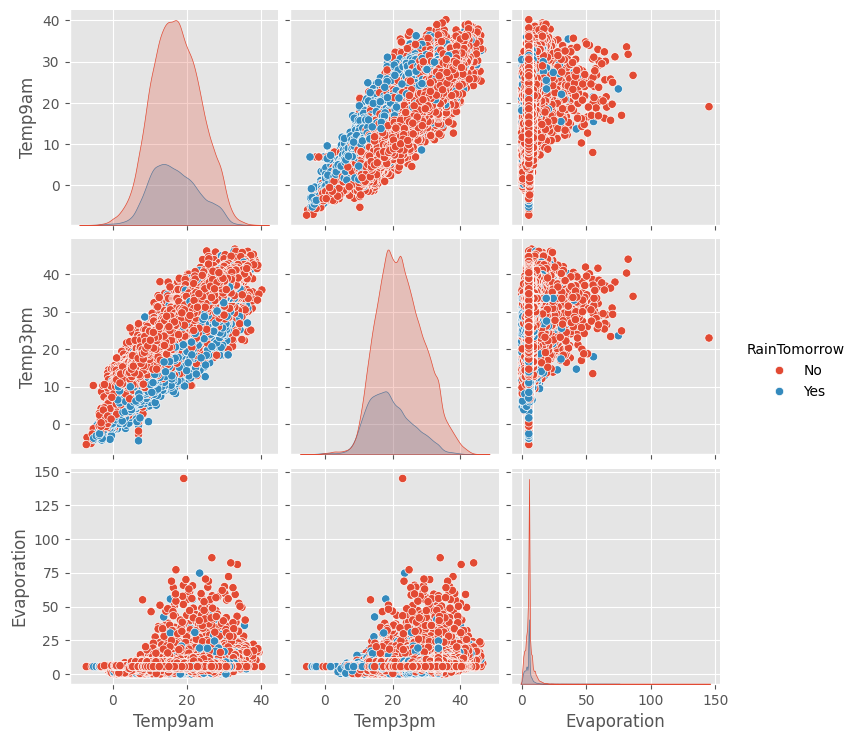

In [32]:
sns.pairplot(data=df, vars=('Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow')
plt.show()

In [33]:
windspeed_df = df.groupby(['Location'])[['WindSpeed9am', 'WindSpeed3pm']].mean()
windspeed_df = windspeed_df.reset_index()

fig = px.line(windspeed_df, x ='Location', y = windspeed_df.columns, title = 'Location-wise: Average WindSpeed', markers=True)
fig.update_yaxes(title_text = 'Windspeed')
fig.update_layout(xaxis=dict(tickangle=45, mirror = True))

In [34]:
del windspeed_df
humidity_df = df.groupby(['Location'])[['Humidity9am', 'Humidity3pm']].mean()
humidity_df = humidity_df.reset_index()

fig = px.line(humidity_df, x ='Location', y = humidity_df.columns, title = 'Location-wise: Average Humidity', markers=True)
fig.update_yaxes(title_text = 'Humidity')
fig.update_layout(xaxis=dict(tickangle=45, mirror = True))

In [35]:
del humidity_df
pressure_df = df.groupby(['Location'])[['Pressure9am', 'Pressure3pm']].mean()
pressure_df = pressure_df.reset_index()

fig = px.line(pressure_df, x ='Location', y = pressure_df.columns, title = 'Location-wise: Average Pressure', markers=True)
fig.update_yaxes(title_text = 'Pressure')
fig.update_layout(xaxis=dict(tickangle=45, mirror = True))

In [36]:
del pressure_df
temperature_df = df.groupby(['Location'])[['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']].mean()
temperature_df = temperature_df.reset_index()

fig = px.line(temperature_df, x ='Location', y = temperature_df.columns, title = 'Location-wise: Average Temperature', markers=True)
del temperature_df
fig.update_yaxes(title_text = 'Temperature')
fig.update_layout(xaxis=dict(tickangle=45, mirror = True))

##Handling Outliers

In [37]:
def cap_data(df, q1, q3):
    for col in tqdm(df.columns):
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([q1,q3]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

In [38]:
X = cap_data(df, 0.25, 0.75)

100%|██████████| 23/23 [00:00<00:00, 175.71it/s]


In [39]:
eda(X, numerical_features)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
Minimum,7.6,17.9,0.0,3.851730,7.367293,31.0,7.0,13.0,57.0,37.0,1013.5,1011.0,3.000000,3.24298,12.2,16.7
Maximum,16.8,28.2,0.8,6.000000,9.000000,46.0,19.0,24.0,83.0,66.0,1021.8,1019.4,6.407059,6.00000,21.5,26.4
Mode,16.8,28.2,0.0,5.472516,7.630540,31.0,19.0,13.0,57.0,37.0,1021.8,1019.4,3.000000,6.00000,21.5,16.7


In [40]:
get_nan(X).T

""
Total
Percent


##Categorical Encoding

In [41]:
X[categorical_features].nunique()

Date            3436
Location          49
WindGustDir       65
WindDir9am        16
WindDir3pm        16
RainToday          2
RainTomorrow       2
dtype: int64

In [42]:
df['Date'] = pd.to_datetime(df['Date'])

In [43]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [44]:
df.drop(['Date'], axis = 1, inplace = True)

In [45]:
categorical_features.remove('Date')

In [46]:
X[categorical_features].nunique()

Location        49
WindGustDir     65
WindDir9am      16
WindDir3pm      16
RainToday        2
RainTomorrow     2
dtype: int64

In [47]:
encoder = OneHotEncoder(drop = 'first', sparse = False)
X_cat = encoder.fit_transform(X[categorical_features])
X_cat = pd.DataFrame(X_cat, columns = encoder.get_feature_names_out(categorical_features))

X_cat.head()

,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_Albany,WindGustDir_Albury,WindGustDir_AliceSprings,WindGustDir_BadgerysCreek,WindGustDir_Ballarat,WindGustDir_Bendigo,WindGustDir_Brisbane,WindGustDir_Cairns,WindGustDir_Canberra,WindGustDir_Cobar,WindGustDir_CoffsHarbour,WindGustDir_Dartmoor,WindGustDir_Darwin,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_GoldCoast,WindGustDir_Hobart,WindGustDir_Katherine,WindGustDir_Launceston,WindGustDir_Melbourne,WindGustDir_MelbourneAirport,WindGustDir_Mildura,WindGustDir_Moree,WindGustDir_MountGambier,WindGustDir_MountGinini,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_Newcastle,WindGustDir_Nhil,WindGustDir_NorahHead,WindGustDir_NorfolkIsland,WindGustDir_Nuriootpa,WindGustDir_PearceRAAF,WindGustDir_Penrith,WindGustDir_Perth,WindGustDir_PerthAirport,WindGustDir_Portland,WindGustDir_Richmond,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_Sale,WindGustDir_SalmonGums,WindGustDir_Sydney,WindGustDir_SydneyAirport,WindGustDir_Townsville,WindGustDir_Tuggeranong,WindGustDir_Uluru,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_WaggaWagga,WindGustDir_Walpole,WindGustDir_Watsonia,WindGustDir_Williamtown,WindGustDir_Witchcliffe,WindGustDir_Wollongong,WindGustDir_Woomera,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,RainTomorrow_Yes
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [48]:
X = pd.concat([X[numerical_features], X_cat], axis = 1)
X.dropna(inplace = True)
X.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_Albany,WindGustDir_Albury,WindGustDir_AliceSprings,WindGustDir_BadgerysCreek,WindGustDir_Ballarat,WindGustDir_Bendigo,WindGustDir_Brisbane,WindGustDir_Cairns,WindGustDir_Canberra,WindGustDir_Cobar,WindGustDir_CoffsHarbour,WindGustDir_Dartmoor,WindGustDir_Darwin,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_GoldCoast,WindGustDir_Hobart,WindGustDir_Katherine,WindGustDir_Launceston,WindGustDir_Melbourne,WindGustDir_MelbourneAirport,WindGustDir_Mildura,WindGustDir_Moree,WindGustDir_MountGambier,WindGustDir_MountGinini,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_Newcastle,WindGustDir_Nhil,WindGustDir_NorahHead,WindGustDir_NorfolkIsland,WindGustDir_Nuriootpa,WindGustDir_PearceRAAF,WindGustDir_Penrith,WindGustDir_Perth,WindGustDir_PerthAirport,WindGustDir_Portland,WindGustDir_Richmond,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_Sale,WindGustDir_SalmonGums,WindGustDir_Sydney,WindGustDir_SydneyAirport,WindGustDir_Townsville,WindGustDir_Tuggeranong,WindGustDir_Uluru,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_WaggaWagga,WindGustDir_Walpole,WindGustDir_Watsonia,WindGustDir_Williamtown,WindGustDir_Witchcliffe,WindGustDir_Wollongong,WindGustDir_Woomera,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,RainTomorrow_Yes
0,13.4,22.9,0.6,5.472516,7.63054,44.0,19.0,24.0,71.0,37.0,1013.5,1011.0,6.407059,5.426638,16.9,21.8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,7.6,25.1,0.0,5.472516,7.63054,44.0,7.0,22.0,57.0,37.0,1013.5,1011.0,6.407059,5.426638,17.2,24.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,

##Handling Imbalanced Dataset

In [49]:
majority_class_data = X[X.RainTomorrow_Yes == 0.0]
minority_class_data = X[X.RainTomorrow_Yes == 1.0]

upsampled_minority_class = resample(minority_class_data, replace=True, n_samples=len(majority_class_data))
X = pd.concat([majority_class_data, upsampled_minority_class], axis=0)

print(X['RainTomorrow_Yes'].value_counts())
X.shape

RainTomorrow_Yes
0.0    105907
1.0    105907
Name: count, dtype: int64


(211814, 160)

In [50]:
y = X['RainTomorrow_Yes']
X.drop(columns = ['RainTomorrow_Yes'], inplace = True)

##Feature Selection

In [51]:
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(list(X.columns[selector.get_support(indices=True)]))

['Location_AliceSprings', 'Location_Portland', 'Location_Uluru', 'Location_Woomera', 'WindGustDir_E', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NNW', 'WindDir9am_SE', 'RainToday_Yes']


##Data Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
cv = StratifiedKFold(n_splits = 8, shuffle = True)

##Feature Scaling

In [53]:
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

##PCA

In [54]:
pca = PCA(n_components = 10)

X_train_new = pd.DataFrame(pca.fit_transform(X_train[numerical_features]),
                           columns = ['Col_'+ str(i) for i in range(10)], index = X_train.index)
X_test_new = pd.DataFrame(pca.transform(X_test[numerical_features]),
                          columns = ['Col_'+ str(i) for i in range(10)], index = X_test.index)

print(X_train_new.shape, X_test_new.shape)

(169451, 10) (42363, 10)


In [55]:
X_train = pd.concat([X_train_new, X_train.iloc[:, 17:]], ignore_index = True, axis = 1)
X_test = pd.concat([X_test_new, X_test.iloc[:, 17:]], ignore_index = True, axis = 1)

##Modeling

In [56]:
def train_model_with_random_search(model, param_grid, X_train, y_train, X_test, y_test, skf):

    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10,
                                       scoring='accuracy', n_jobs=-1, cv=skf)

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_param = random_search.best_params_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)

    print('Accuracy: ', accuracy)
    print('F1 Score: ', f1)
    print('AUC(ROC): ', roc_auc)
    print()
    print("Classification Report: ")
    print(classification_report(y_test, y_pred))

    prob = best_model.predict_proba(X_test)
    prob = prob[:, 1]
    fper, tper, _ = roc_curve(y_test, prob)
    auc_scr = auc(fper, tper)


    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    axes[0].plot(fper, tper, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_scr)
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc="lower right")

    sns.heatmap(confusion_matrix(y_test, y_pred), ax = axes[1], annot = True, cbar = False, fmt='.0f')
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('Actual labels')

    plt.show()

    return model, accuracy, f1, roc_auc, best_param

##Logistic Regression

Accuracy:  0.6746217217855204
F1 Score:  0.6715494390564762
AUC(ROC):  0.6741442849895254

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.65      0.77      0.70     21287
         1.0       0.71      0.58      0.64     21076

    accuracy                           0.67     42363
   macro avg       0.68      0.67      0.67     42363
weighted avg       0.68      0.67      0.67     42363



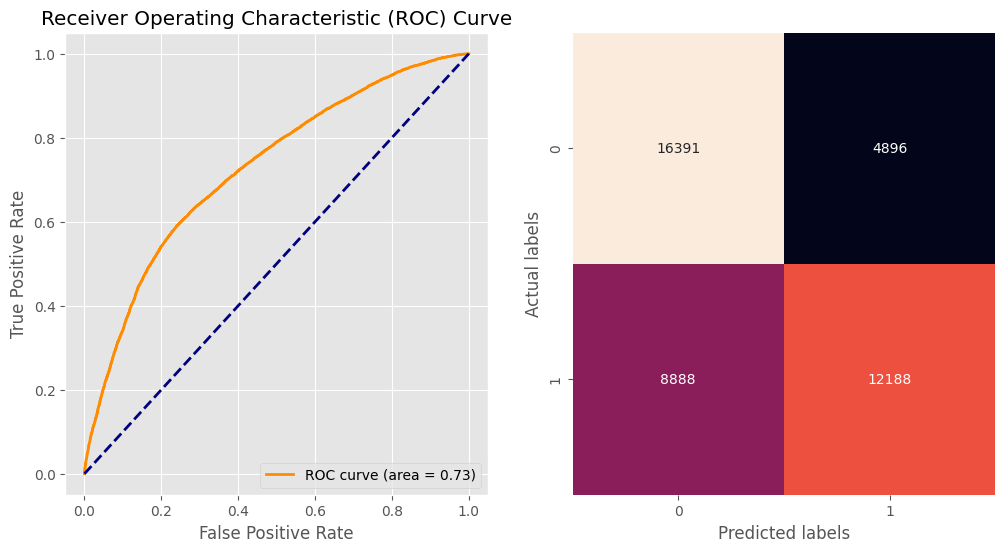

In [57]:
log_reg_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'liblinear'],
    'max_iter': [100, 200, 300, 400, 500]
}


model_lr = LogisticRegression()
time_start = time.time()
model_lr, acc_lr, f1_lr, roc_auc_lr, param_lr = train_model_with_random_search(model_lr, log_reg_param_grid,
                                                                     X_train, y_train, X_test, y_test, cv)
time_taken_lr = time.time() - time_start

In [58]:
print('Best Parameters: ', param_lr)
print("Time Taken: ", round(time_taken_lr, 2), ' Seconds')

Best Parameters:  {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 0.01}
Time Taken:  216.25  Seconds


##Decision Tree

Accuracy:  0.865259778580365
F1 Score:  0.8644854884062316
AUC(ROC):  0.8656456134390784

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.93      0.79      0.85     21287
         1.0       0.82      0.94      0.87     21076

    accuracy                           0.87     42363
   macro avg       0.87      0.87      0.86     42363
weighted avg       0.87      0.87      0.86     42363



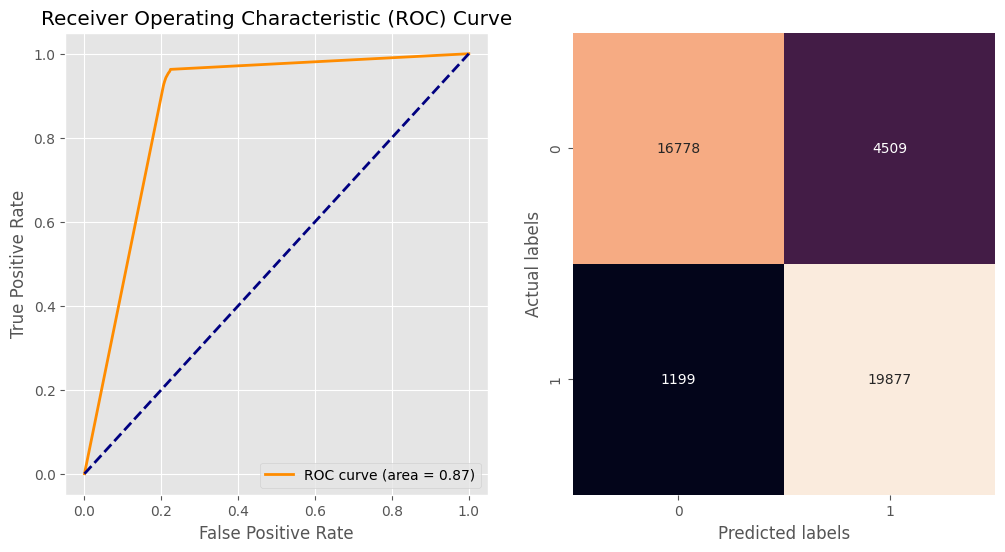

In [59]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


model_dt = DecisionTreeClassifier()

time_start = time.time()
model_dt, acc_dt, f1_dt, roc_auc_dt, param_dt = train_model_with_random_search(model_dt, dt_param_grid,
                                                                    X_train, y_train, X_test, y_test, cv)
time_taken_dt = time.time() - time_start

In [60]:
print('Best Parameters: ', param_dt)
print("Time Taken: ", round(time_taken_dt, 2), ' Seconds')

Best Parameters:  {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}
Time Taken:  592.56  Seconds


##Random Forest

Accuracy:  0.9157755588603262
F1 Score:  0.9156826222648746
AUC(ROC):  0.9159517150507025

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     21287
         1.0       0.89      0.95      0.92     21076

    accuracy                           0.92     42363
   macro avg       0.92      0.92      0.92     42363
weighted avg       0.92      0.92      0.92     42363



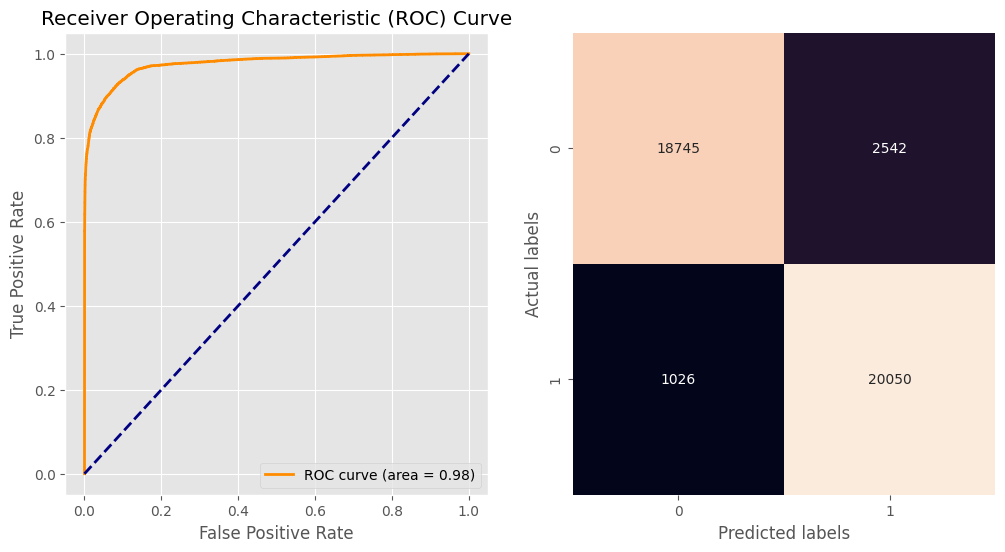

In [61]:
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'criterion': ['gini'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

model_rf = RandomForestClassifier()

time_start = time.time()
model_rf, acc_rf, f1_rf, roc_auc_rf, param_rf = train_model_with_random_search(model_rf, rf_param_grid,
                                                                    X_train, y_train, X_test, y_test, cv)
time_taken_rf = time.time() - time_start

In [62]:
print('Best Parameters: ', param_rf)
print("Time Taken: ", round(time_taken_rf, 2), ' Seconds')

Best Parameters:  {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40, 'criterion': 'gini', 'bootstrap': False}
Time Taken:  8443.74  Seconds


##XGBoost

Accuracy:  0.8403795765172438
F1 Score:  0.84029606596403
AUC(ROC):  0.8405025989690927

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84     21287
         1.0       0.82      0.87      0.84     21076

    accuracy                           0.84     42363
   macro avg       0.84      0.84      0.84     42363
weighted avg       0.84      0.84      0.84     42363



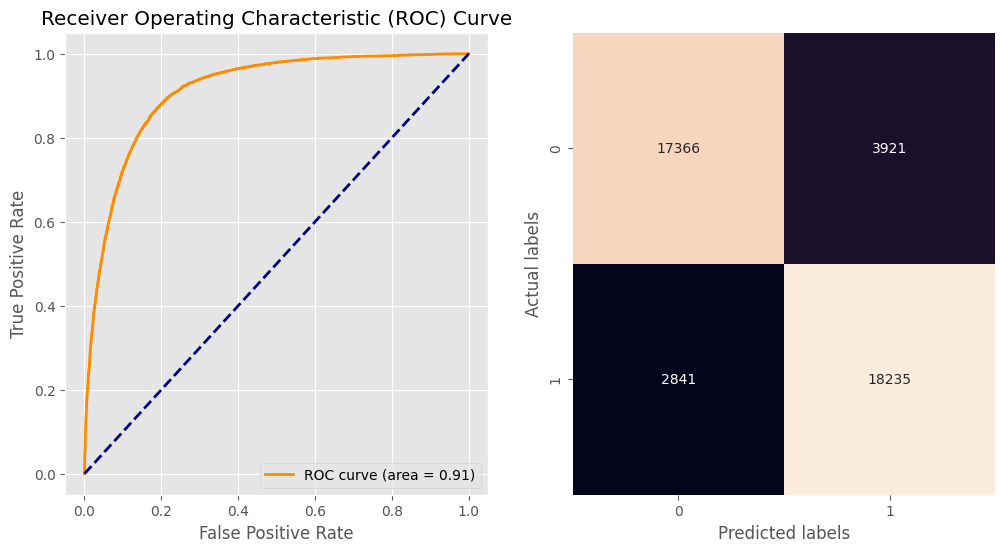

In [65]:
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0, 1, 5]
}

model_xgb = xgb.XGBClassifier()

time_start = time.time()
model_xgb, acc_xgb, f1_xgb, roc_auc_xgb, param_xgb = train_model_with_random_search(model_xgb, xgb_param_grid,
                                                                        X_train, y_train, X_test, y_test, cv)
time_taken_xgb = time.time() - time_start

In [66]:
print('Best Parameters: ', param_xgb)
print("Time Taken: ", round(time_taken_xgb, 2), ' Seconds')

Best Parameters:  {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
Time Taken:  1156.3  Seconds


##Model Comparison

In [67]:
accuracies = [acc_lr, acc_dt, acc_rf, acc_xgb]
f_score = [f1_lr, f1_dt, f1_rf, f1_xgb]
roc_auc = [roc_auc_lr, roc_auc_dt, roc_auc_rf, roc_auc_xgb]
time = [time_taken_lr, time_taken_dt, time_taken_rf, time_taken_xgb]

final_df = pd.DataFrame({"Accuracies": accuracies, "F1 Scores": f_score, "ROC AUC": roc_auc, "Time Taken": time},
                       index = ['LogisticReg', 'DecisionTree', 'RandomForest', 'XGB'])
final_df = final_df.round(4)
final_df

,Accuracies,F1 Scores,ROC AUC,Time Taken
LogisticReg,0.6746,0.6715,0.6741,216.2460
DecisionTree,0.8653,0.8645,0.8656,592.5577
RandomForest,0.9158,0.9157,0.9160,8443.7412
XGB,0.8404,0.8403,0.8405,1156.2953


In [68]:
px.line(final_df, x = final_df.index, y = ['F1 Scores', 'ROC AUC'])

In [69]:
px.line(final_df, x = final_df.index, y = ['Time Taken'], labels = {'index': 'Models', 'value':'No. of Seconds'})